In [16]:
from resemblyzer import preprocess_wav, VoiceEncoder
from resemblyzer.audio import sampling_rate
from pathlib import Path
import numpy as np
from resemblyzer import *
import warnings
warnings.filterwarnings('ignore')

# DEMO 02: we'll show how this similarity measure can be used to perform speaker diarization
# (telling who is speaking when in a recording).


## Get reference audios
# Load the interview audio from disk
# Source for the interview: https://www.youtube.com/watch?v=X2zqiX6yL3I
wav_fpath = Path("audio_data_X2zqiX6yL3I.mp3")
wav = preprocess_wav(wav_fpath)

# Cut some segments from single speakers as reference audio
segments = [[0, 5.5], [6.5, 12], [17, 25]]
speaker_names = ["Kyle Gass", "Sean Evans", "Jack Black"]
speaker_wavs = [wav[int(s[0] * sampling_rate):int(s[1] * sampling_rate)] for s in segments]
# print(speaker_wavs)
    
## Compare speaker embeds to the continuous embedding of the interview
# Derive a continuous embedding of the interview. We put a rate of 16, meaning that an 
# embedding is generated every 0.0625 seconds. It is good to have a higher rate for speaker 
# diarization, but it is not so useful for when you only need a summary embedding of the 
# entire utterance. A rate of 2 would have been enough, but 16 is nice for the sake of the 
# demonstration. 
encoder = VoiceEncoder("cuda")
print("Running the continuous embedding on gpu, this might take a while...")
_, cont_embeds, wav_splits = encoder.embed_utterance(wav, return_partials=True, rate=16)


# Get the continuous similarity for every speaker. It amounts to a dot product between the 
# embedding of the speaker and the continuous embedding of the interview
speaker_embeds = [encoder.embed_utterance(speaker_wav) for speaker_wav in speaker_wavs]
similarity_dict = {name: cont_embeds @ speaker_embed for name, speaker_embed in 
                   zip(speaker_names, speaker_embeds)}

similarity_dict

[array([ 1.7729668e-05,  1.8443194e-05,  3.3761124e-05, ...,
       -4.1197296e-02, -4.9448043e-02, -4.0105861e-02], dtype=float32), array([-0.0091072 , -0.01602904, -0.01422718, ..., -0.13147393,
       -0.18648523, -0.19281963], dtype=float32), array([ 0.0713425 ,  0.08885378,  0.09167311, ..., -0.28003737,
       -0.24149689, -0.13232876], dtype=float32)]
Loaded the voice encoder model on cuda in 0.25 seconds.
Running the continuous embedding on gpu, this might take a while...


{'Kyle Gass': array([0.85990906, 0.86013687, 0.8479381 , ..., 0.6048521 , 0.5966388 ,
        0.6078812 ], dtype=float32),
 'Sean Evans': array([0.7191262 , 0.7247914 , 0.74373883, ..., 0.49776605, 0.50936097,
        0.5191069 ], dtype=float32),
 'Jack Black': array([0.69949   , 0.70445627, 0.71908987, ..., 0.633959  , 0.6327871 ,
        0.643449  ], dtype=float32)}

Failed to play audio: PortAudioError('Error querying device -1')


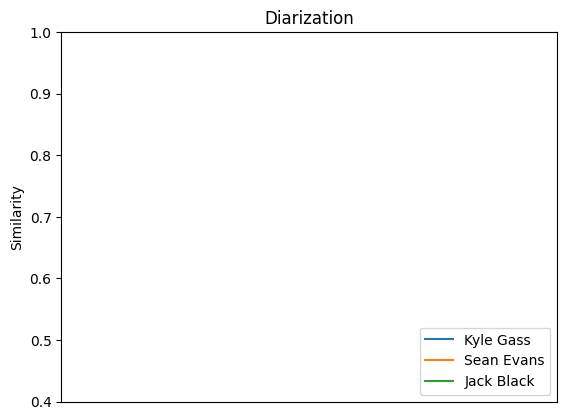

In [17]:
# import demo_utils.py
from matplotlib import cm
from time import sleep, perf_counter as timer
# from umap import UMAP
from sys import stderr
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation

_default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
_my_colors = np.array([
    [0, 127, 70],
    [255, 0, 0],
    [255, 217, 38],
    [0, 135, 255],
    [165, 0, 165],
    [255, 167, 255],
    [97, 142, 151],
    [0, 255, 255],
    [255, 96, 38],
    [142, 76, 0],
    [33, 0, 127],
    [0, 0, 0],
    [183, 183, 183],
    [76, 255, 0],
], dtype=np.float) / 255 


def play_wav(wav, blocking=True):
    try:
        import sounddevice as sd
        # Small bug with sounddevice.play: the audio is cut 0.5 second too early. We pad it to 
        # make up for that
        wav = np.concatenate((wav, np.zeros(sampling_rate // 2)))
        sd.play(wav, sampling_rate, blocking=blocking)
    except Exception as e:
        print("Failed to play audio: %s" % repr(e))


def interactive_diarization(similarity_dict, wav, wav_splits, x_crop=5, show_time=False):
    fig, ax = plt.subplots()
    lines = [ax.plot([], [], label=name)[0] for name in similarity_dict.keys()]
    text = ax.text(0, 0, "", fontsize=10)
    
    def init():
        ax.set_ylim(0.4, 1)
        ax.set_ylabel("Similarity")
        if show_time:
            ax.set_xlabel("Time (seconds)")
        else:
            ax.set_xticks([])
        ax.set_title("Diarization")
        ax.legend(loc="lower right")
        return lines + [text]
    
    times = [((s.start + s.stop) / 2) / sampling_rate for s in wav_splits]
    rate = 1 / (times[1] - times[0])
    crop_range = int(np.round(x_crop * rate))
    ticks = np.arange(0, len(wav_splits), rate)
    ref_time = timer()
    
     
    def update(i):
        # Crop plot
        crop = (max(i - crop_range // 2, 0), i + crop_range // 2)
        ax.set_xlim(i - crop_range // 2, crop[1])
        if show_time:
            crop_ticks = ticks[(crop[0] <= ticks) * (ticks <= crop[1])]
            ax.set_xticks(crop_ticks)
            ax.set_xticklabels(np.round(crop_ticks / rate).astype(np.int))

        # Plot the prediction
        similarities = [s[i] for s in similarity_dict.values()]
        best = np.argmax(similarities)
        name, similarity = list(similarity_dict.keys())[best], similarities[best]
        if similarity > 0.75:
            message = "Speaker: %s (confident)" % name
            color = _default_colors[best]
        elif similarity > 0.65:
            message = "Speaker: %s (uncertain)" % name
            color = _default_colors[best]
        else:
            message = "Unknown/No speaker"
            color = "black"
        text.set_text(message)
        text.set_c(color)
        text.set_position((i, 0.96))
        
        # Plot data
        for line, (name, similarities) in zip(lines, similarity_dict.items()):
            line.set_data(range(crop[0], i + 1), similarities[crop[0]:i + 1])
        
        # Block to synchronize with the audio (interval is not reliable)
        current_time = timer() - ref_time
        if current_time < times[i]:
            sleep(times[i] - current_time)
        elif current_time - 0.2 > times[i]:
            print("Animation is delayed further than 200ms!", file=stderr)
        return lines + [text]
    
    ani = FuncAnimation(fig, update, frames=len(wav_splits), init_func=init, blit=not show_time,
                        repeat=False, interval=1)
    play_wav(wav, blocking=False)
    plt.show()



## Run the interactive demo
interactive_diarization(similarity_dict, wav, wav_splits)

In [ ]:
from resemblyzer import VoiceEncoder, preprocess_wav
from pathlib import Path
import numpy as np

fpath = Path("audio_data_X2zqiX6yL3I.wav")
wav = preprocess_wav(fpath)

encoder = VoiceEncoder()
embed = encoder.embed_utterance(wav)
np.set_printoptions(precision=3, suppress=True)
print(embed)

In [1]:
!pip install resemblyzer


  Using cached Resemblyzer-0.1.1.dev0-py3-none-any.whl (15.7 MB)
  Using cached typing-3.7.4.3.tar.gz (78 kB)
  Using cached webrtcvad-2.0.10.tar.gz (66 kB)
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26324 sha256=85c4073c9f26e2c6f768d46c02ec44cdf428202c351cfad9d2c6262bde622572
  Stored in directory: /root/.cache/pip/wheels/5e/5d/01/3083e091b57809dad979ea543def62d9d878950e3e74f0c930
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp38-cp38-linux_x86_64.whl size=81087 sha256=3ee22ab60c0fe36fe35345023fd90f526aa6cdfe03e442834af1d444657358a8
  Stored in directory: /root/.cache/pip/wheels/75/e1/fc/01099a9fd0882ce84cc99eb51495812bb8a703461c2b0ca1cb
Successfully built typing webrtcvad
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
